In [1]:
import torch
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import data.dataset as ds
import numpy as np
import torchvision
from torch.utils.data import DataLoader, random_split
# import albumentations as A

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import model_ae_FD as vae


/home/lai075/miniconda3/envs/hf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Welcome to eht-imaging! v 1.2.8 



In [2]:
if False:
    model = vae.Vae_FD().to(device)
    model = torch.load('../models/model.pt').to(device)
    model.eval()


In [3]:
# plot all images in the batch
def plot_images(images):
    fig, axes = plt.subplots(2, len(images)//2, figsize=(len(images)//2*0.99, 2))
    fig.subplots_adjust(hspace=0., wspace=0.)
    axes = axes.flatten()
    for ax, img in zip(axes, images):
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')


In [4]:
# Randomly split the dataset into training and validation sets and then save

if False:
    import glob

    files = glob.glob('data/datasets/v3/imgs_*128.npy')

    for f in files:
        data = np.load(f)
        np.random.shuffle(data)
        train_size = int(len(data) * 0.8)
        val_size = len(data) - train_size
        train_data, val_data = data[:train_size], data[train_size:]
        np.save(f.replace('imgs_', 'train/train_'), train_data)
        np.save(f.replace('imgs_', 'val/val_'), val_data)
        print(f, train_data.shape, val_data.shape)

In [9]:
def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = 0.05
    
    out = img + sigma * torch.randn_like(img)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

def square_taper(img, square_size_range=(32, 48), blur_fwhm_range=(5, 10), fixed=False):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    h, w = img.shape[-2:]
    if fixed:
        square_size = square_size_range
        blur_fwhm = blur_fwhm_range
    else:
        square_size = np.random.randint(*square_size_range)
        blur_fwhm = np.random.uniform(*blur_fwhm_range)

    # taper mask
    taper = torch.zeros_like(img)
    taper[:, h//2-square_size//2:h//2+square_size//2, w//2-square_size//2:w//2+square_size//2] = 1
    taper = v2.GaussianBlur(25, sigma=blur_fwhm)(taper)
    
    out = img * taper
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

def radial_taper(img, radii_range=(8, 24), blur_fwhm_range=(5, 10), fixed=False):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    h, w = img.shape[-2:]
    if fixed:
        radius = radii_range
        blur_fwhm = blur_fwhm_range
    else:
        radius = np.random.randint(*radii_range)
        blur_fwhm = np.random.uniform(*blur_fwhm_range)

    # radial taper mask
    taper = torch.zeros_like(img)
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w))
    y = y - h//2
    x = x - w//2
    r = torch.sqrt(x**2 + y**2)
    taper[:, r<radius] = 1
    taper = v2.GaussianBlur(15, sigma=blur_fwhm)(taper)
    
    out = img * taper
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

def fixed_taper(img, size = 16, blur_fwhm = 5):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)

    out = radial_taper(img, size, blur_fwhm, fixed=True)
    

    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out




train_transforms = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomAffine(degrees=(-90, 90), scale=(0.8, 1.), shear=(-5, 5), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    v2.CenterCrop(64),
    v2.Normalize([0], [0.2]),
])

val_transforms = v2.Compose([
    v2.ToTensor(),
    v2.CenterCrop(64),
])

cifar_train_transforms = v2.Compose([
    v2.ToTensor(),
    v2.Resize(64),
    gauss_noise_tensor,
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomAffine(degrees=(-90, 90), scale=(0.8, 1.), shear=(-5, 5), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    radial_taper,
    v2.CenterCrop(64),
])

cifar_val_transforms = v2.Compose([
    v2.ToTensor(),
    v2.Resize(64),
    fixed_taper,
    v2.CenterCrop(64),
])

transforms_dict = {
    'train': train_transforms,
    'val': val_transforms,
    'cifar_train': cifar_train_transforms,
    'cifar_val': cifar_val_transforms,
}



Loading text image:  ./data/template_sgra.txt
Loading text image:  ./data/template_sgra.txt
torch.Size([32, 700])


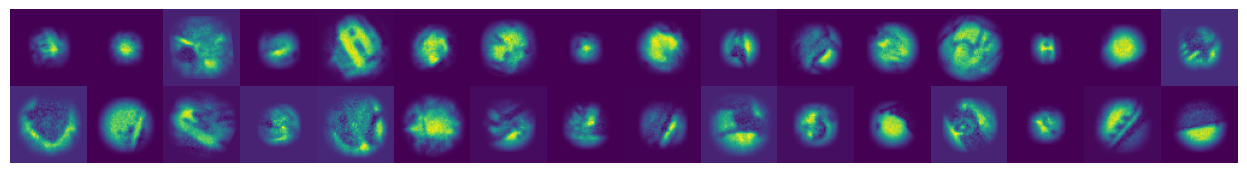

In [10]:
batch_size = 32

ehtim=True
tint_sec = 5   
tadv_sec = 600
tstart_hr = 0
tstop_hr = 5
bw_hz = [230E9, 345E9]

data_dir = 'data/datasets/v2/'
# mnames = ['gauss', 'disk', 'ellipse', 'ring', 'mring', 'disk2', 'gauss2']
mnames = ['cifar10']

filenames = np.array([data_dir + 'train/train_' + m + '.npy' for m in mnames])
train_data = ds.ImgDataset(filenames, transform=cifar_train_transforms, ehtim=ehtim, tint_sec=tint_sec, tadv_sec=tadv_sec, tstart_hr=tstart_hr, tstop_hr=tstop_hr, bw_hz=bw_hz)

filenames = np.array([data_dir + 'val/val_' + m + '.npy' for m in mnames])
val_data = ds.ImgDataset(filenames, transform=cifar_val_transforms, ehtim=ehtim, tint_sec=tint_sec, tadv_sec=tadv_sec, tstart_hr=tstart_hr, tstop_hr=tstop_hr, bw_hz=bw_hz)


train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val = DataLoader(val_data, batch_size=batch_size, shuffle=True)

if True:
    dataiter = iter(train)
    images, cis, classes = next(dataiter)
    print(cis.shape)

    plot_images(images)

    if False:
        with torch.inference_mode():
            features_vae, features_q, features_ci, recon_img, pred_img, pred_class = model(images.to(device), cis.to(device))
            plot_images(recon_img.cpu().detach())
            plot_images(pred_img.cpu().detach())


        

In [56]:
# test decoder from ci
from torch import nn

test = np.random.random_sample((10, 120, 1, 1))

decoder = nn.Sequential(
    nn.ConvTranspose2d(120, 64, 4, 1, 0),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(64, 32, 4, 2, 1),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(32, 4, 4, 2, 1),
)

out = decoder(torch.tensor(test, dtype=torch.float32))
print(out.shape)

test = np.random.random_sample((10, 120))

# turn it into a tensor of shape 120 x1 x1
test = torch.Tensor(test)
test = test.unsqueeze(2).unsqueeze(3)
print(test.shape)


torch.Size([10, 4, 16, 16])
torch.Size([10, 120, 1, 1])


In [6]:
# save images as jpegs
import glob

files = glob.glob('data/datasets/v2/imgs_*.npy')
i = 0 
for f in files:
    data = np.load(f)
    for n, img in enumerate(data):
        plt.imsave(f.replace('imgs_', 'jpegs/').replace('.npy', '_{}.jpg'.format(n)), img)
        i += 1
    print(f, data.shape)

data/datasets/v2/imgs_disk.npy (512, 128, 128)
data/datasets/v2/imgs_mring.npy (9180, 128, 128)
data/datasets/v2/imgs_gauss.npy (512, 128, 128)
data/datasets/v2/imgs_ellipse.npy (2048, 128, 128)
data/datasets/v2/imgs_ring.npy (1024, 128, 128)


In [1]:
# Test CI and CI_torch
import data.CI as ci
import data.CI_torch as ci_torch
import numpy as np
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_img = np.zeros((5, 5))
test_img[2, 2] = 1
test_img[1, 1] = 1

ci_test = ci.Closure_Invariants(ehtim=True, ehtarray='data/EHT2017.txt', tstop_hr=5.6)
ci_torch_test = ci_torch.Closure_Invariants(ehtim=True, ehtarray='data/EHT2017.txt', tstop_hr=5.6)

# print(ci_test.uvlist)
# print(ci_torch_test.uvlist)

# print(ci_test.antenna_list)
# print(ci_torch_test.antenna_list)

for uv, num_antenna in zip(ci_test.uvlist, ci_test.antenna_list):
    vis = ci_test.Visibilities(np.array([test_img, test_img]), uv)
    temp_ci = ci_test.ClosureInvariants(vis, num_antenna)
    temp_ci = temp_ci.reshape(1, -1)
    print(temp_ci)

for uv, num_antenna in zip(ci_torch_test.uvlist, ci_torch_test.antenna_list):
    vis = ci_torch_test.Visibilities(torch.tensor([test_img, test_img]).to(device), torch.tensor(uv, dtype=torch.float32).to(device))
    temp_ci = ci_torch_test.ClosureInvariants(vis, num_antenna)
    temp_ci = temp_ci.reshape(1, -1)
    print(temp_ci)



res1 = ci_test.FTCI(np.array([test_img]))
res2 = ci_torch_test.FTCI(np.array([test_img]))

# print(res1)
# print(res2)



Welcome to eht-imaging! v 1.2.8 

Loading text image:  ./data/template_sgra.txt
Loading text image:  ./data/template_sgra.txt
[[ 1.72277975e-01  1.91056456e-02 -2.12968707e-02  1.78662738e-01
  -5.28465535e-01 -2.60829043e-01 -1.06285207e-01  9.97230004e-02
   1.25171462e-02  6.05758028e-02  3.25114275e-02 -2.97469456e-01
   1.13120654e-01 -2.22824380e-01  1.66561219e-01 -3.00302376e-09
   1.64589256e-01 -3.67024983e-01  7.47797242e-03  3.18830666e-01
   1.26841226e-01  1.00000000e+00 -4.15786300e-02  5.99568350e-02
  -9.69446304e-02 -9.27811585e-02  8.48918715e-01 -2.54742987e-02
   5.01733195e-02  1.04158473e-01  1.72277975e-01  1.91056456e-02
  -2.12968707e-02  1.78662738e-01 -5.28465535e-01 -2.60829043e-01
  -1.06285207e-01  9.97230004e-02  1.25171462e-02  6.05758028e-02
   3.25114275e-02 -2.97469456e-01  1.13120654e-01 -2.22824380e-01
   1.66561219e-01 -3.00302376e-09  1.64589256e-01 -3.67024983e-01
   7.47797242e-03  3.18830666e-01  1.26841226e-01  1.00000000e+00
  -4.15786300e-0